In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label', 'message'])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
messages['message length'] = messages['message'].apply(len)

In [5]:
messages.head()

,label,message,message length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
messages.groupby('label').describe()

message length                                                         
               count        mean        std   min    25%    50%    75%    max
label                                                                        
ham           4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam           747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

### Visualisieren

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: ylabel='Frequency'>

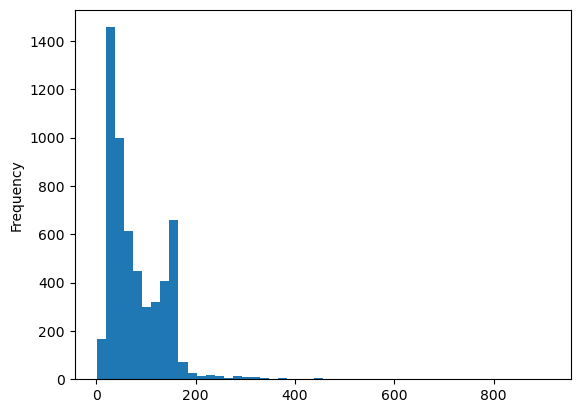

In [8]:
messages['message length'].plot(bins=50, kind='hist')

In [9]:
messages['message length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: message length, dtype: float64

In [10]:
messages[messages['message length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

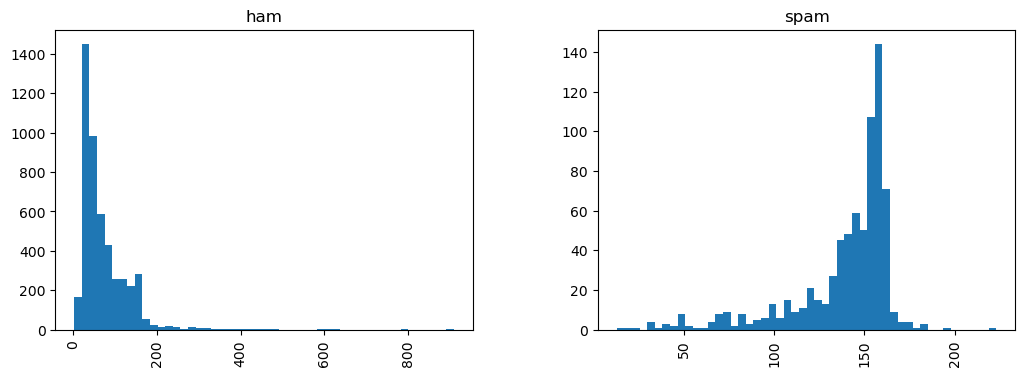

In [11]:
messages.hist(column='message length', by='label', bins=50, figsize=(12,4))

### Pre processing

In [12]:
import string 
from nltk.corpus import stopwords

def text_process(mess):
    """
    Nimmt einen String von Text und führt das folgende durch:
    1. Entferne alle Zeichensetzung
    2. Entferne alle Stoppwörter
    3. Gebe eine Liste des gesäuberten Texts zurück
    """
    # 1.
    nopunc = [char for char in mess if char not in string.punctuation]

    # 2.
    nopunc = ''.join(nopunc)
    
    # 3.
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [13]:
messages['message'].apply(text_process)

0       [Go, jurong, point, crazy, Available, bugis, n...
1                          [Ok, lar, Joking, wif, u, oni]
2       [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3           [U, dun, say, early, hor, U, c, already, say]
4       [Nah, dont, think, goes, usf, lives, around, t...
                              ...                        
5567    [2nd, time, tried, 2, contact, u, U, £750, Pou...
5568                   [ü, b, going, esplanade, fr, home]
5569                     [Pity, mood, Soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [Rofl, true, name]
Name: message, Length: 5572, dtype: object

#### Vektorisierung

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

In [16]:
messages_bow = bow_transformer.transform(messages['message'])

In [17]:
messages_bow.shape

(5572, 11425)

In [18]:
# Amount of Non-Zero occurences

messages_bow.nnz

50548

In [19]:
"""
berechne die "Sparsity" einer Matrix. 
In diesem Fall wird die Sparsity für die messages_bow Matrix berechnet, 
die durch das Bag-of-Words-Verfahren erstellt wurde.
"""

sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


#### TF-IDF

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer

In [21]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [22]:
messages_tfidf = tfidf_transformer.transform(messages_bow)

In [23]:
print(messages_tfidf.shape)

(5572, 11425)


In [24]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['free']])

3.2800524267409408
4.934340905340393


#### Model trainieren 

In [25]:
X = messages_tfidf
y = messages['label']

In [26]:
X.shape, y.shape

((5572, 11425), (5572,))

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4457, 11425), (1115, 11425), (4457,), (1115,))

In [29]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train, y_train)

In [30]:
y_pred = model.predict(X_test)
print(y_pred)

['ham' 'ham' 'ham' ... 'ham' 'ham' 'ham']


#### Model auswerten

In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9614349775784753


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.71      0.83       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.90      1115
weighted avg       0.96      0.96      0.96      1115



In [33]:
pd.crosstab(y_test, y_pred)

col_0,ham,spam
label,,
ham,966,0
spam,43,106


In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[966   0]
 [ 43 106]]


In [35]:
import numpy as np
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_norm)

[[1.        0.       ]
 [0.2885906 0.7114094]]


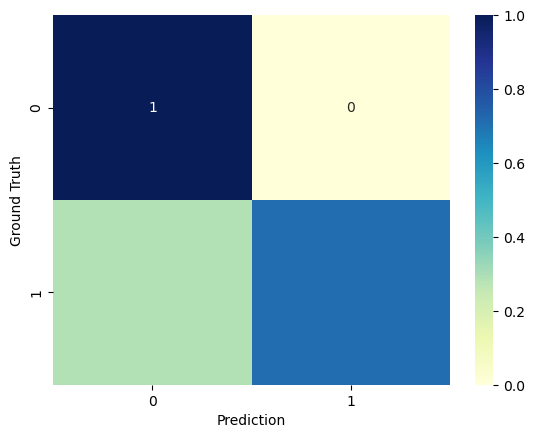

In [36]:
import seaborn as sns
figure = plt.gcf()
ax = figure.add_subplot(111)
sns.heatmap(cm_norm, annot=True, cmap="YlGnBu")
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth');

### SVM

In [37]:
from sklearn.svm import SVC

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
messages['Label'] = le.fit_transform(messages['label'])

In [39]:
messages.head()

,label,message,message length,Label
0,ham,"Go until jurong point, crazy.. Available only ...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,1
3,ham,U dun say so early hor... U c already then say...,49,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,0


In [40]:
ys = messages['Label']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.20, random_state=42, stratify=y)

In [42]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC()

In [43]:
y_pred =  svm_model.predict(X_test)

In [44]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.9587443946188341


In [46]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[965   1]
 [ 45 104]]


In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.70      0.82       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115

